# Régression Quantile : Application sur le Dataset de Risque de Crédit

## Introduction Mathématique

La **régression quantile** est une extension de la régression linéaire et/ou polynomiale qui modélise les quantiles conditionnels de la variable de réponse plutôt que sa moyenne conditionnelle.

## Application au Risque de Crédit

Ce notebook applique la régression quantile au dataset **Financial Risk for Loan Approval** pour modéliser la relation entre le ratio d'endettement et le score de risque, permettant :

1. **Estimation de scénarios de risque** (optimiste, central, pessimiste)
2. **Quantification de l'incertitude** dans l'évaluation du risque de crédit
3. **Construction d'intervalles de confiance** pour l'aide à la décision

In [25]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data_loading import load_regression_data
from preprocessing import prepare_regression_data

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Chargement des données

In [26]:
df_raw = load_regression_data()

print("Taille du dataset:", df_raw.shape)

# Suppression de la date
if 'ApplicationDate' in df_raw.columns:
    df_raw = df_raw.drop(columns=['ApplicationDate'])

target_column = 'RiskScore'

# Suppression de LoanApproved
if 'LoanApproved' in df_raw.columns:
    df_raw = df_raw.drop(columns=['LoanApproved'])

print("\nVariables:", list(df_raw.columns))
print("\nPremières lignes:")
df_raw.head()

Chargement du dataset de régression: /home/r-one/Documents/epita/stochastique/Prediction-Conforme-et-Regression-Quantile-sur-le-Risque-de-Credit/data/raw/Loan.csv
Dataset chargé: 20000 lignes, 36 colonnes
Taille du dataset: (20000, 36)

Variables: ['Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus', 'EducationLevel', 'Experience', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'RiskScore']

Premières lignes:


,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,...,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,RiskScore
0,45,39948,617,Employed,Master,22,13152,48,Married,2,...,19183,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,49.0
1,38,39709,628,Employed,Associate,15,26045,48,Single,1,...,9595,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,52.0
2,47,40724,570,Employed,Bachelor,26,17627,36,Married,2,...,128874,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,52.0
3,58,69084,545,Employed,High School,34,37898,96,Single,1,...,5370,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,54.0
4,37,103264,594,Employed,Associate,17,9184,36,Married,1,...,17286,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,36.0


## 2. Rappel EDA : Corrélations avec la cible

On affiche la matrice de corrélation pour identifier les features les plus pertinentes

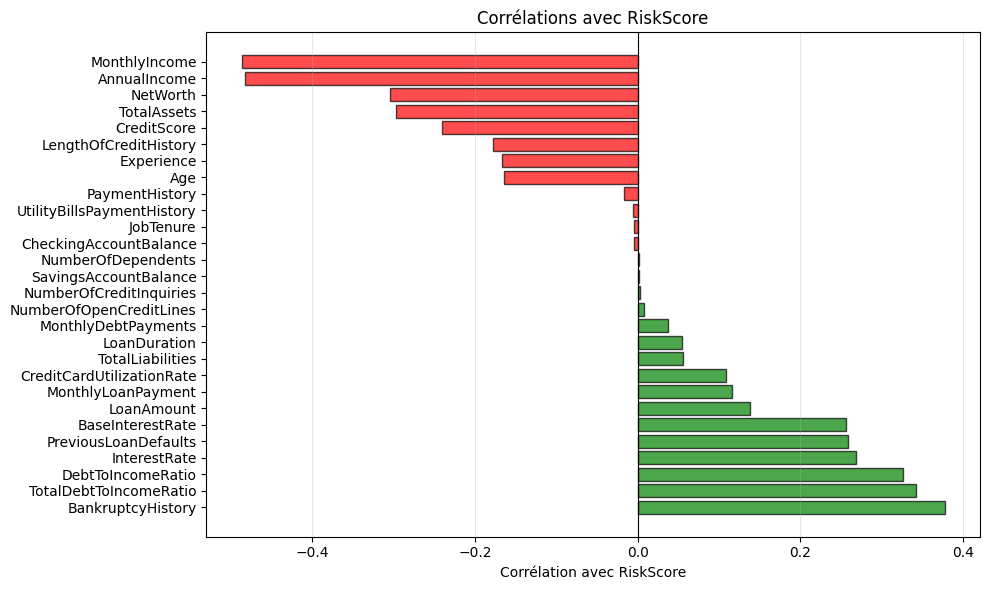


Corrélations:
BankruptcyHistory: 0.378
TotalDebtToIncomeRatio: 0.343
DebtToIncomeRatio: 0.327
InterestRate: 0.268
PreviousLoanDefaults: 0.259
BaseInterestRate: 0.256
LoanAmount: 0.138
MonthlyLoanPayment: 0.116
CreditCardUtilizationRate: 0.109
TotalLiabilities: 0.056
LoanDuration: 0.055
MonthlyDebtPayments: 0.037
NumberOfOpenCreditLines: 0.008
NumberOfCreditInquiries: 0.003
SavingsAccountBalance: 0.002
NumberOfDependents: 0.002
CheckingAccountBalance: -0.004
JobTenure: -0.004
UtilityBillsPaymentHistory: -0.005
PaymentHistory: -0.017
Age: -0.164
Experience: -0.166
LengthOfCreditHistory: -0.178
CreditScore: -0.240
TotalAssets: -0.297
NetWorth: -0.304
AnnualIncome: -0.483
MonthlyIncome: -0.487

Features continues: ['Age', 'AnnualIncome', 'CreditScore', 'Experience', 'LoanAmount', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'DebtToIncomeRatio', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIn

In [27]:
numeric_features = [col for col in df_raw.select_dtypes(include=[np.number]).columns if col != target_column]
correlations = df_raw[numeric_features + [target_column]].corr()[target_column].drop(target_column)
correlations_sorted = correlations.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in correlations_sorted.values]
plt.barh(range(len(correlations_sorted)), correlations_sorted.values, color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(correlations_sorted)), correlations_sorted.index)
plt.xlabel('Corrélation avec RiskScore')
plt.title('Corrélations avec RiskScore')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCorrélations:")
for var, corr in correlations_sorted.items():
    print(f"{var}: {corr:.3f}")
    
continuous_features = []
for col in numeric_features:
    n_unique = df_raw[col].nunique()
    if n_unique > 20:
        continuous_features.append(col)

print(f"\nFeatures continues: {continuous_features}")

correlations_continuous = correlations[correlations.index.isin(continuous_features)]
if len(correlations_continuous) > 0:
    most_correlated_continuous = correlations_continuous.abs().idxmax()
    print(f"\nFeature la plus corrélée: {most_correlated_continuous} ({correlations[most_correlated_continuous]:.3f})")
else:
    most_correlated_continuous = correlations.abs().idxmax()
    print(f"\nFeature la plus corrélée: {most_correlated_continuous} ({correlations[most_correlated_continuous]:.3f})")

## 3. Protocole de Régression Quantile Standard : 3 Modèles

### Objectif de la Régression Quantile

La régression quantile ne modélise pas seulement la **moyenne conditionnelle** (comme la régression linéaire classique) mais les **quantiles conditionnels** de la distribution de la variable cible.

**Pourquoi 3 modèles différents ?**

Nous allons comparer **3 configurations de features** pour évaluer l'impact du nombre de variables sur :
1. **La précision des prédictions** (erreur médiane)
2. **La calibration des intervalles** (taux de couverture)
3. **La largeur des intervalles de prédiction** (incertitude quantifiée)

---

### Configuration des 3 Modèles

#### **Modèle 1 : Une seule feature (la plus corrélée)**
- **Avantage** : Simplicité, interprétabilité maximale, visualisation 2D possible
- **Inconvénient** : Capture une relation univariée, peut manquer des patterns multivariés

#### **Modèle 2 : Toutes les features disponibles**
- **Avantage** : Utilise toute l'information disponible, capture les interactions complexes
- **Inconvénient** : Risque de surapprentissage, plus difficile à interpréter

#### **Modèle 3 : Features modérément corrélées (|corr| >= 0.1)**
- **Avantage** : Compromis entre simplicité et performance, réduit le bruit
- **Inconvénient** : Dépend du seuil de corrélation choisi

---

### Choix des Quantiles : $\beta = 0.1$

Nous fixons **$\beta = 0.1$** pour obtenir un **intervalle de confiance à 90%**.

Ainsi, nous entraînons **3 régressions quantiles par modèle** :
- **$Q_{0.05}$** : Borne inférieure (scénario optimiste pour le risque)
- **$Q_{0.50}$** : Médiane conditionnelle (prédiction centrale)
- **$Q_{0.95}$** : Borne supérieure (scénario pessimiste pour le risque)

**Interprétation financière** :
- 90% des nouveaux clients devraient avoir un RiskScore dans l'intervalle prédit
- Permet d'évaluer le pire cas (Q95) pour la gestion du risque
- Plus robuste aux valeurs extrêmes que la moyenne conditionnelle

---

### Évaluation de la Performance : Coverage (Couverture)

Le **taux de couverture empirique** mesure si notre modèle est **bien calibré** :

$$\text{Coverage} = \frac{1}{n_{test}} \sum_{i=1}^{n_{test}} \mathbb{1}_{Q_{0.05}(y_i|X_i) \leq y_i \leq Q_{0.95}(y_i|X_i)}$$

**Critère de validation** :
- Si **Coverage ≈ 90%** → Modèle bien calibré
- Si **Coverage < 90%** → Intervalles trop étroits
- Si **Coverage > 90%** → Intervalles trop larges

## 4. Préparation des Données

**Prétraitement appliqué :**
1. **One-hot encoding** : Les variables catégorielles (EmploymentStatus, EducationLevel, etc.) sont converties en variables binaires pour être utilisables par le modèle linéaire
2. **Normalisation (StandardScaler)** : Centrage et réduction des features pour :
   - Améliorer la convergence du solver
   - Rendre les coefficients comparables entre eux
   - Éviter que des features à grande échelle dominent le modèle

In [28]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = prepare_regression_data(
    df_raw,
    target_column=target_column,
    test_size=0.33,
    random_state=RANDOM_STATE 
)

print("Shape avant traitement:", X_train.shape)

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_cols:
    print("Variables catégorielles:", categorical_cols)
    X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
    print("Après one-hot encoding:", X_train.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Shape final:", X_train.shape)

Préparation des données de régression - Target: RiskScore
Statistiques de la variable cible:
count    20000.000000
mean        50.766780
std          7.778262
min         28.800000
25%         46.000000
50%         52.000000
75%         56.000000
max         84.000000
Name: RiskScore, dtype: float64
Données d'entraînement: (13400, 33)
Données de test: (6600, 33)
Shape avant traitement: (13400, 33)
Variables catégorielles: ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']
Après one-hot encoding: (13400, 44)
Shape final: (13400, 44)


## 5. Entraînement des Régressions Quantiles

**Configuration :**
- $\beta=0.1$ pour obtenir une couverture d'ordre $1-\beta=0.9$ (donc une couverture à 90%)
- On veut un intervalle de prédiction symétrique, on utilise donc les quantiles d'ordre $\frac{\beta}{2}$ et $1-\frac{\beta}{2}$, qui entoure le quantile médian ($\tau=0.5$)

In [29]:
from sklearn.linear_model import QuantileRegressor

beta = 0.1
quantiles = [beta/2, 0.5, 1-beta/2]

available_features = X_train.columns.tolist()

numeric_features_original = [col for col in df_raw.select_dtypes(include=[np.number]).columns 
                             if col != target_column and col in available_features]

correlations_available = correlations[correlations.index.isin(numeric_features_original)]

if len(correlations_available) > 0:
    correlations_abs = correlations_available.abs().sort_values(ascending=False)
    
    if most_correlated_continuous in available_features:
        most_correlated = most_correlated_continuous
    else:
        most_correlated = correlations_abs.index[0]
    
    moderately_correlated = correlations_abs[correlations_abs >= 0.3].index.tolist()
else:
    most_correlated = available_features[0]
    moderately_correlated = available_features[:min(10, len(available_features))]

print(f"Feature la plus corrélée: {most_correlated} ({correlations[most_correlated]:.3f})")
print(f"Features corrélées (|corr| >= 0.1): {len(moderately_correlated)}")
print(moderately_correlated)

feature_configs = {
    'Modèle 1 (1 feature)': [most_correlated],
    'Modèle 2 (toutes features)': available_features,
    'Modèle 3 (features corrélées)': moderately_correlated
}

Feature la plus corrélée: MonthlyIncome (-0.487)
Features corrélées (|corr| >= 0.1): 6
['MonthlyIncome', 'AnnualIncome', 'BankruptcyHistory', 'TotalDebtToIncomeRatio', 'DebtToIncomeRatio', 'NetWorth']


In [30]:
models = {}
for config_name, features in feature_configs.items():
    models[config_name] = {}
    print(f"\n{config_name}: {len(features)} features")
    
    for q in quantiles:
        qr = QuantileRegressor(quantile=q, alpha=0, solver='highs')
        qr.fit(X_train[features], y_train)
        models[config_name][q] = qr
        print(f"  Quantile {q:.2f} Terminé")


Modèle 1 (1 feature): 1 features
  Quantile 0.05 Terminé
  Quantile 0.50 Terminé
  Quantile 0.95 Terminé

Modèle 2 (toutes features): 44 features
  Quantile 0.05 Terminé
  Quantile 0.50 Terminé
  Quantile 0.95 Terminé

Modèle 3 (features corrélées): 6 features
  Quantile 0.05 Terminé
  Quantile 0.50 Terminé
  Quantile 0.95 Terminé


## Evaluation des modèles

## 6. Visualisation des Résultats

Comme dans le notebook du cours, nous visualisons :
1. **Modèle 1 (1 feature)** : Graph 2D montrant les 3 quantiles et l'intervalle de prédiction
2. **Modèles 2 et 3** : Scatter plot des prédictions vs valeurs réelles avec intervalles

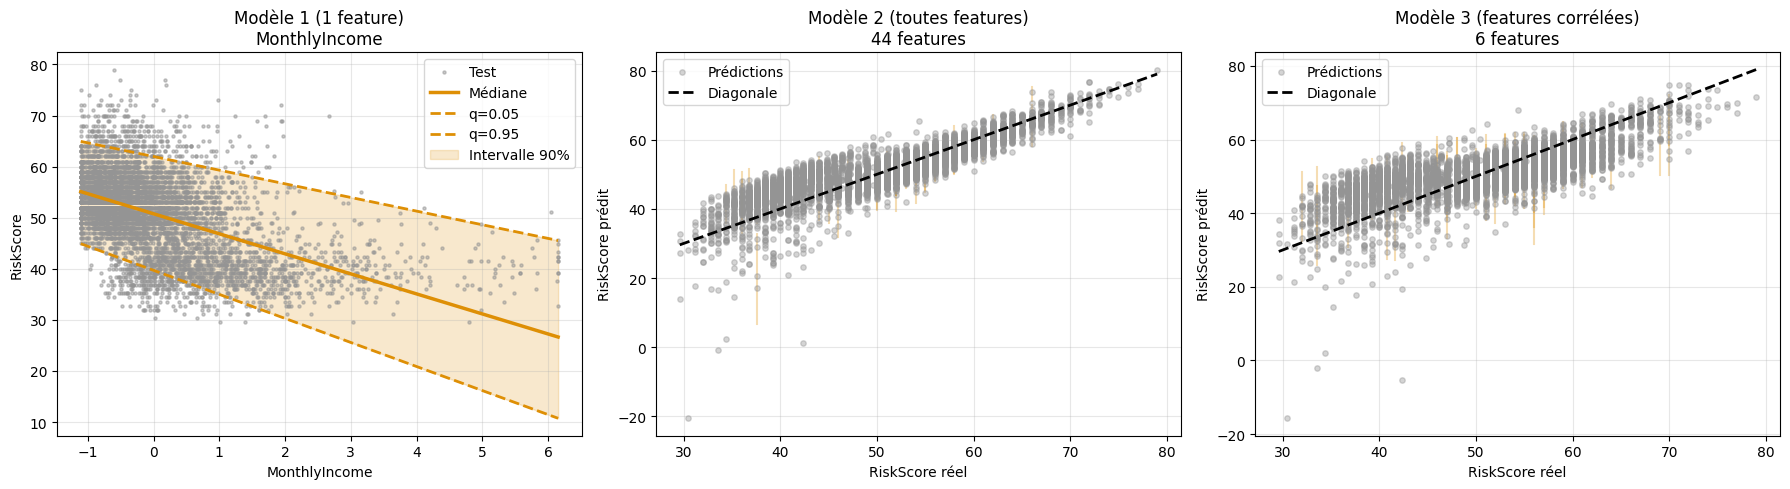

In [36]:
colors_blindness = sns.color_palette("colorblind")
color_train = colors_blindness[1]
color_test = colors_blindness[7]
color_true = colors_blindness[4]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (config_name, features) in enumerate(feature_configs.items()):
    if idx == 0:
        ax = axes[0]
        
        X_plot = X_test[features].values.flatten()
        sort_idx = np.argsort(X_plot)
        X_sorted = X_plot[sort_idx]
        y_sorted = y_test.values[sort_idx]
        
        predictions = {}
        for q in quantiles:
            pred = models[config_name][q].predict(X_test[features])
            predictions[q] = pred[sort_idx]
        
        ax.scatter(X_test[features], y_test, marker='.', color=color_test, alpha=0.5, s=20, label='Test', zorder=2)
        ax.plot(X_sorted, predictions[0.5], '-', color=color_train, linewidth=2.5, label='Médiane', zorder=3)
        ax.plot(X_sorted, predictions[0.05], '--', color=color_train, linewidth=2, label='q=0.05', zorder=3)
        ax.plot(X_sorted, predictions[0.95], '--', color=color_train, linewidth=2, label='q=0.95', zorder=3)
        ax.fill_between(X_sorted, predictions[0.05], predictions[0.95], alpha=0.2, color=color_train, label='Intervalle 90%', zorder=1)
        
        ax.set_xlabel(f'{features[0]}')
        ax.set_ylabel(target_column)
        ax.set_title(f'{config_name}\n{features[0]}')
        ax.legend()
        ax.grid(alpha=0.3)

np.random.seed(RANDOM_STATE)

for idx, (config_name, features) in enumerate(feature_configs.items()):
    if idx > 0:
        ax = axes[idx]
        
        y_pred_median = models[config_name][0.5].predict(X_test[features])
        y_pred_lower = models[config_name][quantiles[0]].predict(X_test[features])
        y_pred_upper = models[config_name][quantiles[2]].predict(X_test[features])
        
        ax.scatter(y_test, y_pred_median, alpha=0.4, s=15, color=color_test, label='Prédictions', zorder=2)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=2, label='Diagonale', zorder=3)
        
        sample_size = min(50, len(y_test))
        sample_idx = np.random.choice(len(y_test), sample_size, replace=False)
        for i in sample_idx:
            ax.plot([y_test.iloc[i], y_test.iloc[i]], 
                   [y_pred_lower[i], y_pred_upper[i]], 
                   color=color_train, alpha=0.3, linewidth=1.5, zorder=1)
        
        ax.set_xlabel('RiskScore réel')
        ax.set_ylabel('RiskScore prédit')
        ax.set_title(f'{config_name}\n{len(features)} features')
        ax.legend()
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluation des modèles (RMSE, Coverage, Largeur interval)

Le principal problème que nous allons rencontrer, c'est d'évaluer la couverture réelle du modèle. Autrement dit:
"Si j'ai de nouvelles données, est ce que mes intervalles de prédiction ont bien une couverture d'au moins 90%?"

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_m1 = {}
y_pred_m2 = {}
y_pred_m3 = {}  
for q in quantiles:
    y_pred_m1[q] = models['Modèle 1 (1 feature)'][q].predict(X_test[[most_correlated]])
    y_pred_m2[q] = models['Modèle 2 (toutes features)'][q].predict(X_test[available_features])
    y_pred_m3[q] = models['Modèle 3 (features corrélées)'][q].predict(X_test[moderately_correlated])

mae_m1 = mean_absolute_error(y_test, y_pred_m1[0.5])
mse_m1 = mean_squared_error(y_test, y_pred_m1[0.5])
rmse_m1 = np.sqrt(mse_m1)   

print(f"\nModèle 1 (1 feature): ")
print(f"  MAE:  {mae_m1:.2f}")
print(f"  RMSE: {rmse_m1:.2f}")

couverture_m1 = np.mean((y_test >= y_pred_m1[0.05]) & (y_test <= y_pred_m1[0.95]))
print(f"  Couverture: {couverture_m1:.2%}")
largeur_moy_m1 = np.mean(y_pred_m1[0.95] - y_pred_m1[0.05])
print(f"  Largeur moyenne: {largeur_moy_m1:.2f}")


mae_m2 = mean_absolute_error(y_test, y_pred_m2[0.5])
mse_m2 = mean_squared_error(y_test, y_pred_m2[0.5])
rmse_m2 = np.sqrt(mse_m2)
print(f"\nModèle 2 (toutes features): ")
print(f"  MAE:  {mae_m2:.2f}")
print(f"  RMSE: {rmse_m2:.2f}")
couverture_m2 = np.mean((y_test >= y_pred_m2[0.05]) & (y_test <= y_pred_m2[0.95]))
print(f"  Couverture: {couverture_m2:.2%}")
largeur_moy_m2 = np.mean(y_pred_m2[0.95] - y_pred_m2[0.05])
print(f"  Largeur moyenne: {largeur_moy_m2:.2f}")


mae_m3 = mean_absolute_error(y_test, y_pred_m3[0.5])
mse_m3 = mean_squared_error(y_test, y_pred_m3[0.5])
rmse_m3 = np.sqrt(mse_m3)
print(f"\nModèle 3 (features corrélées): ")
print(f"  MAE:  {mae_m3:.2f}")
print(f"  RMSE: {rmse_m3:.2f}")
couverture_m3 = np.mean((y_test >= y_pred_m3[0.05]) & (y_test <= y_pred_m3[0.95]))
print(f"  Couverture: {couverture_m3:.2%}")
largeur_moy_m3 = np.mean(y_pred_m3[0.95] - y_pred_m3[0.05])
print(f"  Largeur moyenne: {largeur_moy_m3:.2f}")


Modèle 1 (1 feature): 
  MAE:  5.29
  RMSE: 6.84
  Couverture: 89.45%
  Largeur moyenne: 22.32

Modèle 2 (toutes features): 
  MAE:  2.77
  RMSE: 3.88
  Couverture: 89.11%
  Largeur moyenne: 10.89

Modèle 3 (features corrélées): 
  MAE:  3.84
  RMSE: 5.14
  Couverture: 89.80%
  Largeur moyenne: 16.38


On prends un échantillon de 50 itérations pour assurer un résultat moyen précis et indépendant d'un facteur aléatoire trop important.

Modèle 1 (1 feature): 89.55% ± 0.33%
Modèle 2 (toutes features): 89.12% ± 0.43%
Modèle 3 (features corrélées): 89.75% ± 0.37%
Modèle 3 (features corrélées): 89.75% ± 0.37%


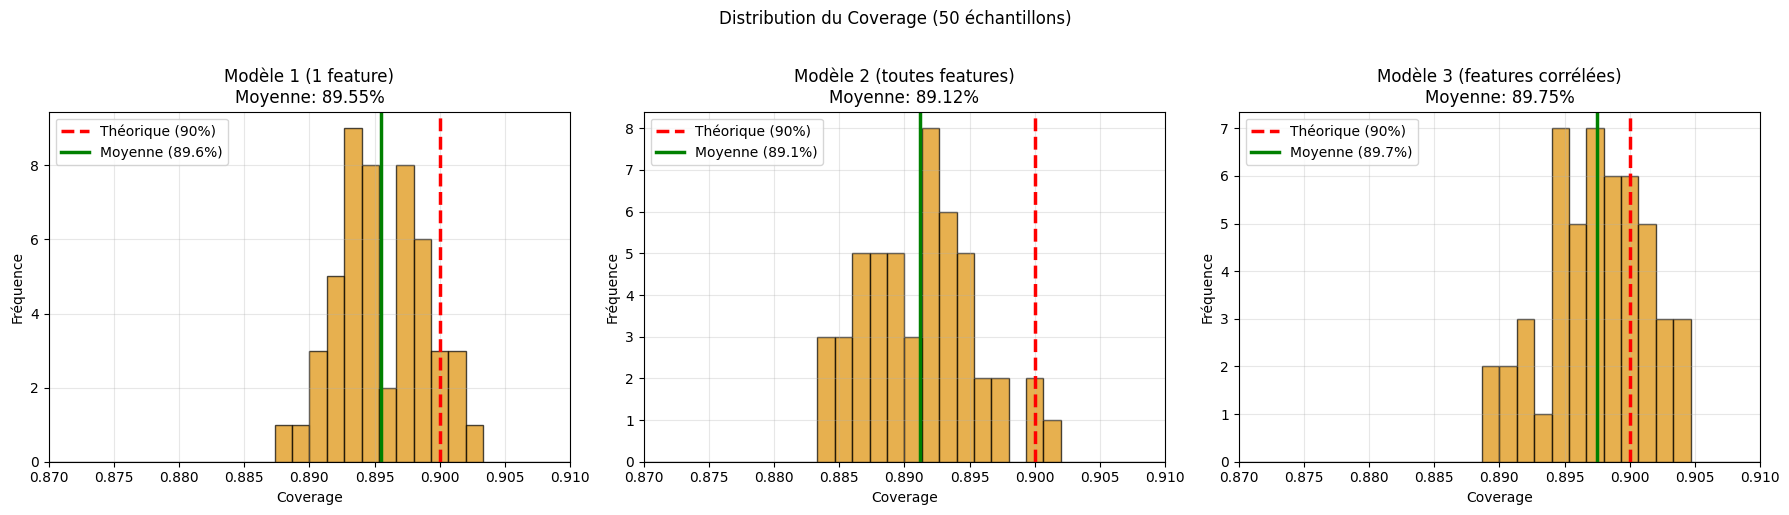


Modèle 1 (1 feature):
  Moyenne: 89.55%
  Écart-type: 0.33%
  Min: 88.86%
  Max: 90.23%

Modèle 2 (toutes features):
  Moyenne: 89.12%
  Écart-type: 0.43%
  Min: 88.35%
  Max: 90.20%

Modèle 3 (features corrélées):
  Moyenne: 89.75%
  Écart-type: 0.37%
  Min: 88.91%
  Max: 90.38%


In [ ]:
def coverage_bootstrap(config_name, features, n_iterations=50):
    coverages = []
    
    for i in range(n_iterations):
        bootstrap_idx = np.random.choice(len(y_test), size=len(y_test), replace=True)
        y_test_boot = y_test.iloc[bootstrap_idx]
        X_test_boot = X_test.iloc[bootstrap_idx]
        
        y_pred_lower = models[config_name][quantiles[0]].predict(X_test_boot[features])
        y_pred_upper = models[config_name][quantiles[2]].predict(X_test_boot[features])
        
        coverage = np.sum((y_pred_lower <= y_test_boot) & (y_test_boot <= y_pred_upper)) / len(y_test_boot)
        coverages.append(coverage)
    
    return np.array(coverages)

bootstrap_results = {}
for config_name, features in feature_configs.items():
    coverages = coverage_bootstrap(config_name, features, n_iterations=50)
    bootstrap_results[config_name] = coverages
    print(f"{config_name}: {np.mean(coverages)*100:.2f}% ± {np.std(coverages)*100:.2f}%")

# Visualisation des distributions de coverage

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

xlim_min = 0.87
xlim_max = 0.91

for idx, (config_name, features) in enumerate(feature_configs.items()):
    ax = axes[idx]
    
    coverages = bootstrap_results[config_name]
    
    ax.hist(coverages, bins=30, color=color_train, alpha=0.7, edgecolor='black', range=(xlim_min, xlim_max))
    
    ax.axvline(x=theor_cov, color='red', linestyle='--', linewidth=2.5, 
               label=f'Théorique ({theor_cov*100:.0f}%)')
    
    mean_cov = np.mean(coverages)
    ax.axvline(x=mean_cov, color='green', linestyle='-', linewidth=2.5, 
               label=f'Moyenne ({mean_cov*100:.1f}%)')
    
    ax.set_xlabel('Coverage')
    ax.set_ylabel('Fréquence')
    ax.set_title(f'{config_name}\nMoyenne: {mean_cov*100:.2f}%')
    ax.set_xlim(xlim_min, xlim_max)
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Distribution du Coverage (50 échantillons)', y=1.02)
plt.tight_layout()
plt.show()

for config_name in feature_configs.keys():
    coverages = bootstrap_results[config_name]
    print(f"\n{config_name}:")
    print(f"  Moyenne: {np.mean(coverages)*100:.2f}%")
    print(f"  Écart-type: {np.std(coverages)*100:.2f}%")
    print(f"  Min: {np.min(coverages)*100:.2f}%")
    print(f"  Max: {np.max(coverages)*100:.2f}%")

# Prédiction sur un nouveau client

In [41]:
exemple_idx = 1
X_exemple = X_test.iloc[exemple_idx:exemple_idx+1]
y_reel = y_test.iloc[exemple_idx]

print(f"Valeur réelle: {y_reel:.2f}")
print()

for config_name, features in feature_configs.items():
    print(f"{config_name} ({len(features)} features):")
    print("-" * 50)
    
    pred_lower = models[config_name][quantiles[0]].predict(X_exemple[features])[0]
    pred_median = models[config_name][0.5].predict(X_exemple[features])[0]
    pred_upper = models[config_name][quantiles[2]].predict(X_exemple[features])[0]
    
    print(f"  Q0.05: {pred_lower:.2f}")
    print(f"  Q0.50: {pred_median:.2f}")
    print(f"  Q0.95: {pred_upper:.2f}")
    print(f"  Intervalle: [{pred_lower:.2f}, {pred_upper:.2f}]")
    print(f"  Largeur: {pred_upper - pred_lower:.2f}")
    
    if pred_lower <= y_reel <= pred_upper:
        print(f"  OK - Dans l'intervalle")
    else:
        print(f"  KO - Hors intervalle")
    print()

print(f"{'Modèle':<30} {'Médiane':<10} {'Largeur':<10} {'OK/KO':<10}")
print("-" * 50)
for config_name, features in feature_configs.items():
    pred_lower = models[config_name][quantiles[0]].predict(X_exemple[features])[0]
    pred_median = models[config_name][0.5].predict(X_exemple[features])[0]
    pred_upper = models[config_name][quantiles[2]].predict(X_exemple[features])[0]
    largeur = pred_upper - pred_lower
    couvert = "OK" if (pred_lower <= y_reel <= pred_upper) else "KO"
    print(f"{config_name:<30} {pred_median:<10.2f} {largeur:<10.2f} {couvert:<10}")

Valeur réelle: 38.40

Modèle 1 (1 feature) (1 features):
--------------------------------------------------
  Q0.05: 24.03
  Q0.50: 37.72
  Q0.95: 53.09
  Intervalle: [24.03, 53.09]
  Largeur: 29.05
  OK - Dans l'intervalle

Modèle 2 (toutes features) (44 features):
--------------------------------------------------
  Q0.05: 29.11
  Q0.50: 37.10
  Q0.95: 46.24
  Intervalle: [29.11, 46.24]
  Largeur: 17.13
  OK - Dans l'intervalle

Modèle 3 (features corrélées) (6 features):
--------------------------------------------------
  Q0.05: 27.41
  Q0.50: 37.11
  Q0.95: 48.81
  Intervalle: [27.41, 48.81]
  Largeur: 21.39
  OK - Dans l'intervalle

Modèle                         Médiane    Largeur    OK/KO     
--------------------------------------------------
Modèle 1 (1 feature)           37.72      29.05      OK        
Modèle 2 (toutes features)     37.10      17.13      OK        
Modèle 3 (features corrélées)  37.11      21.39      OK        


# Régression Quantile Polynomiale

In [42]:
from sklearn.preprocessing import PolynomialFeatures

degree = 2

poly = PolynomialFeatures(degree=degree, include_bias=False)

top_features = [most_correlated]
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

X_train_poly = poly.fit_transform(X_train_reduced)
X_test_poly = poly.transform(X_test_reduced)

print(f"Feature utilisée: {top_features[0]}")
print(f"Corrélation: {correlations[most_correlated]:.3f}")
print(f"Features polynomiales (degré {degree}): {X_train_poly.shape[1]}")
print(f"Transformation: 1 feature -> {X_train_poly.shape[1]} features polynomiales (1, x, x²)")

Feature utilisée: MonthlyIncome
Corrélation: -0.487
Features polynomiales (degré 2): 2
Transformation: 1 feature -> 2 features polynomiales (1, x, x²)


In [43]:
quantiles_poly = [0.05, 0.5, 0.95]
models_poly = {}

for q in quantiles_poly:
    print(f"Entraînement quantile {q}", end="\n")
    qr_poly = QuantileRegressor(quantile=q, alpha=0.01, solver='highs-ds')
    qr_poly.fit(X_train_poly, y_train)
    models_poly[q] = qr_poly
    

Entraînement quantile 0.05
Entraînement quantile 0.5
Entraînement quantile 0.95


## Evaluations

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_poly = {}
for q in quantiles_poly:
    y_pred_poly[q] = models_poly[q].predict(X_test_poly)

mae_poly = mean_absolute_error(y_test, y_pred_poly[0.5])
mse_poly = mean_squared_error(y_test, y_pred_poly[0.5])
rmse_poly = np.sqrt(mse_poly)

print(f"Régression Quantile Polynomiale (degré {degree}):")
print(f"  MAE:  {mae_poly:.2f}")
print(f"  RMSE: {rmse_poly:.2f}")

couverture_poly = np.mean((y_test >= y_pred_poly[0.05]) & (y_test <= y_pred_poly[0.95]))
print(f"  Couverture: {couverture_poly:.2%}")

largeur_moy_poly = np.mean(y_pred_poly[0.95] - y_pred_poly[0.05])
print(f"  Largeur moyenne: {largeur_moy_poly:.2f}")

Régression Quantile Polynomiale (degré 2):
  MAE:  5.23
  RMSE: 6.75
  Couverture: 89.27%
  Largeur moyenne: 22.25


## Visualisations 

/home/r-one/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


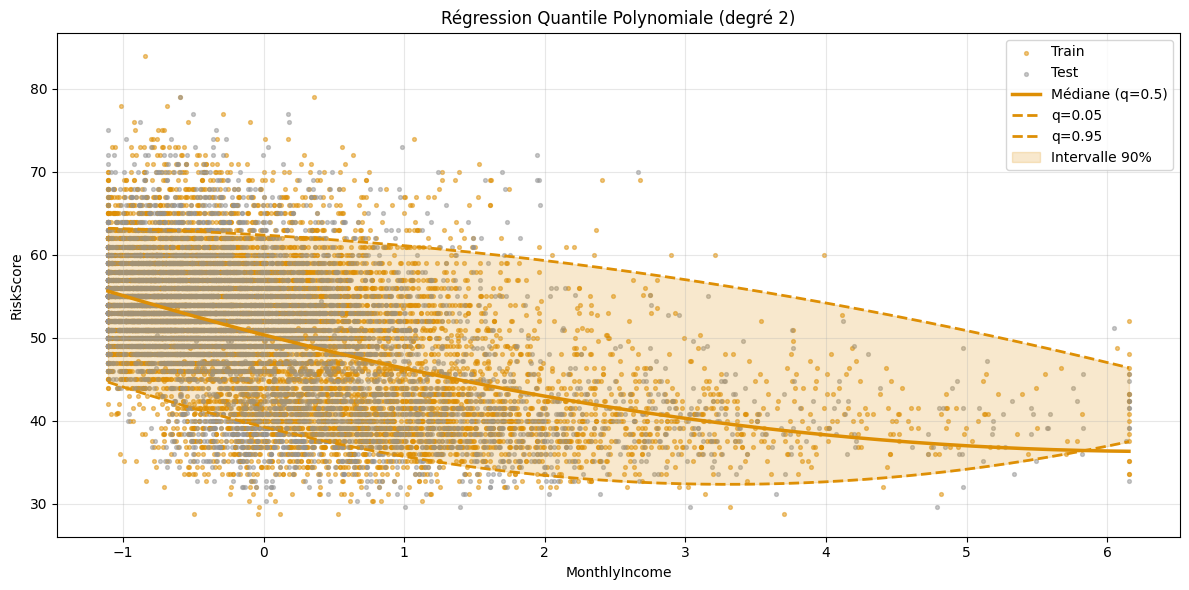

In [47]:
feature_idx = 0
feature_name = top_features[feature_idx]

colors_blindness = sns.color_palette("colorblind")
color_train = colors_blindness[1]
color_test = colors_blindness[7]

plt.figure(figsize=(12, 6))
plt.scatter(X_train_reduced.iloc[:, feature_idx], y_train, marker='.', color=color_train, alpha=0.5, s=30, label='Train')
plt.scatter(X_test_reduced.iloc[:, feature_idx], y_test, marker='.', color=color_test, alpha=0.5, s=30, label='Test')

aux = np.linspace(X_train_reduced.iloc[:, feature_idx].min(), 
                  X_train_reduced.iloc[:, feature_idx].max(), 
                  500)
aux_poly = poly.transform(aux[:, np.newaxis])

plt.plot(aux, models_poly[0.5].predict(aux_poly), color=color_train, linewidth=2.5, label='Médiane (q=0.5)')
plt.plot(aux, models_poly[0.05].predict(aux_poly), '--', color=color_train, linewidth=2, label='q=0.05')
plt.plot(aux, models_poly[0.95].predict(aux_poly), '--', color=color_train, linewidth=2, label='q=0.95')

plt.fill_between(aux, models_poly[0.05].predict(aux_poly), models_poly[0.95].predict(aux_poly), 
                 alpha=0.2, color=color_train, label='Intervalle 90%')

plt.legend()
plt.xlabel(feature_name)
plt.ylabel('RiskScore')
plt.title(f'Régression Quantile Polynomiale (degré {degree})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

On assure à nouveau un score de coverage très précis avec 50 itérations.

Modèle Polynomial (degré 2): 89.25% ± 0.35%


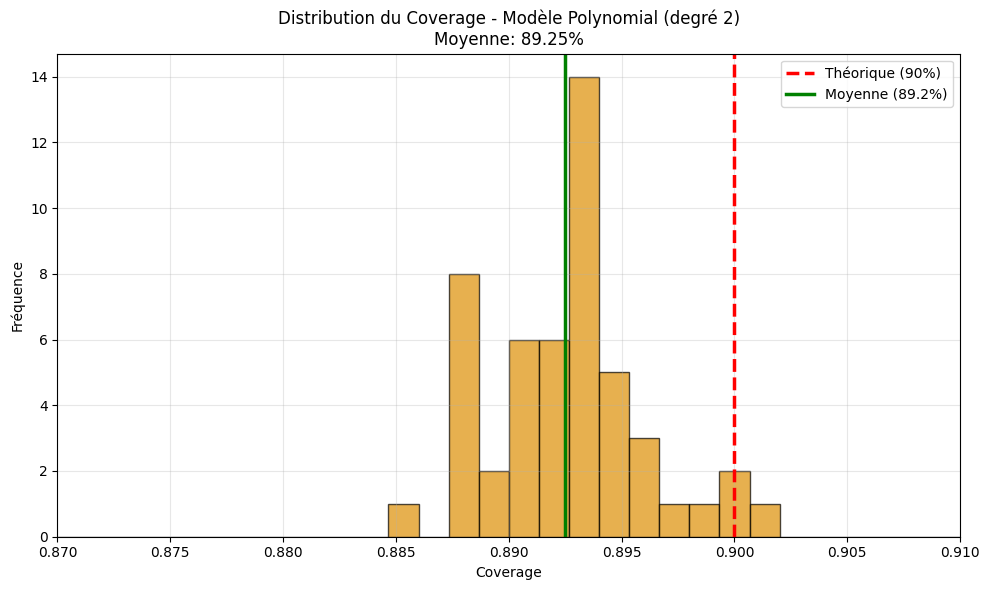


Statistiques détaillées:
  Moyenne: 89.25%
  Écart-type: 0.35%
  Min: 88.52%
  Max: 90.18%


In [54]:
def coverage_bootstrap_poly(n_iterations=50):
    coverages = []
    
    for i in range(n_iterations):
        bootstrap_idx = np.random.choice(len(y_test), size=len(y_test), replace=True)
        y_test_boot = y_test.iloc[bootstrap_idx]
        X_test_boot_poly = X_test_poly[bootstrap_idx]
        
        y_pred_lower = models_poly[0.05].predict(X_test_boot_poly)
        y_pred_upper = models_poly[0.95].predict(X_test_boot_poly)
        
        coverage = np.sum((y_pred_lower <= y_test_boot) & (y_test_boot <= y_pred_upper)) / len(y_test_boot)
        coverages.append(coverage)
    
    return np.array(coverages)

coverages_poly = coverage_bootstrap_poly(n_iterations=50)
print(f"Modèle Polynomial (degré {degree}): {np.mean(coverages_poly)*100:.2f}% ± {np.std(coverages_poly)*100:.2f}%")

# Visualisation
plt.figure(figsize=(10, 6))

xlim_min = 0.87
xlim_max = 0.91

plt.hist(coverages_poly, bins=30, color=color_train, alpha=0.7, edgecolor='black', range=(xlim_min, xlim_max))

theor_cov = 0.9
plt.axvline(x=theor_cov, color='red', linestyle='--', linewidth=2.5, 
           label=f'Théorique ({theor_cov*100:.0f}%)')

mean_cov_poly = np.mean(coverages_poly)
plt.axvline(x=mean_cov_poly, color='green', linestyle='-', linewidth=2.5, 
           label=f'Moyenne ({mean_cov_poly*100:.1f}%)')

plt.xlabel('Coverage')
plt.ylabel('Fréquence')
plt.title(f'Distribution du Coverage - Modèle Polynomial (degré {degree})\nMoyenne: {mean_cov_poly*100:.2f}%')
plt.xlim(xlim_min, xlim_max)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nStatistiques détaillées:")
print(f"  Moyenne: {np.mean(coverages_poly)*100:.2f}%")
print(f"  Écart-type: {np.std(coverages_poly)*100:.2f}%")
print(f"  Min: {np.min(coverages_poly)*100:.2f}%")
print(f"  Max: {np.max(coverages_poly)*100:.2f}%")

# Visualisation comparative complète

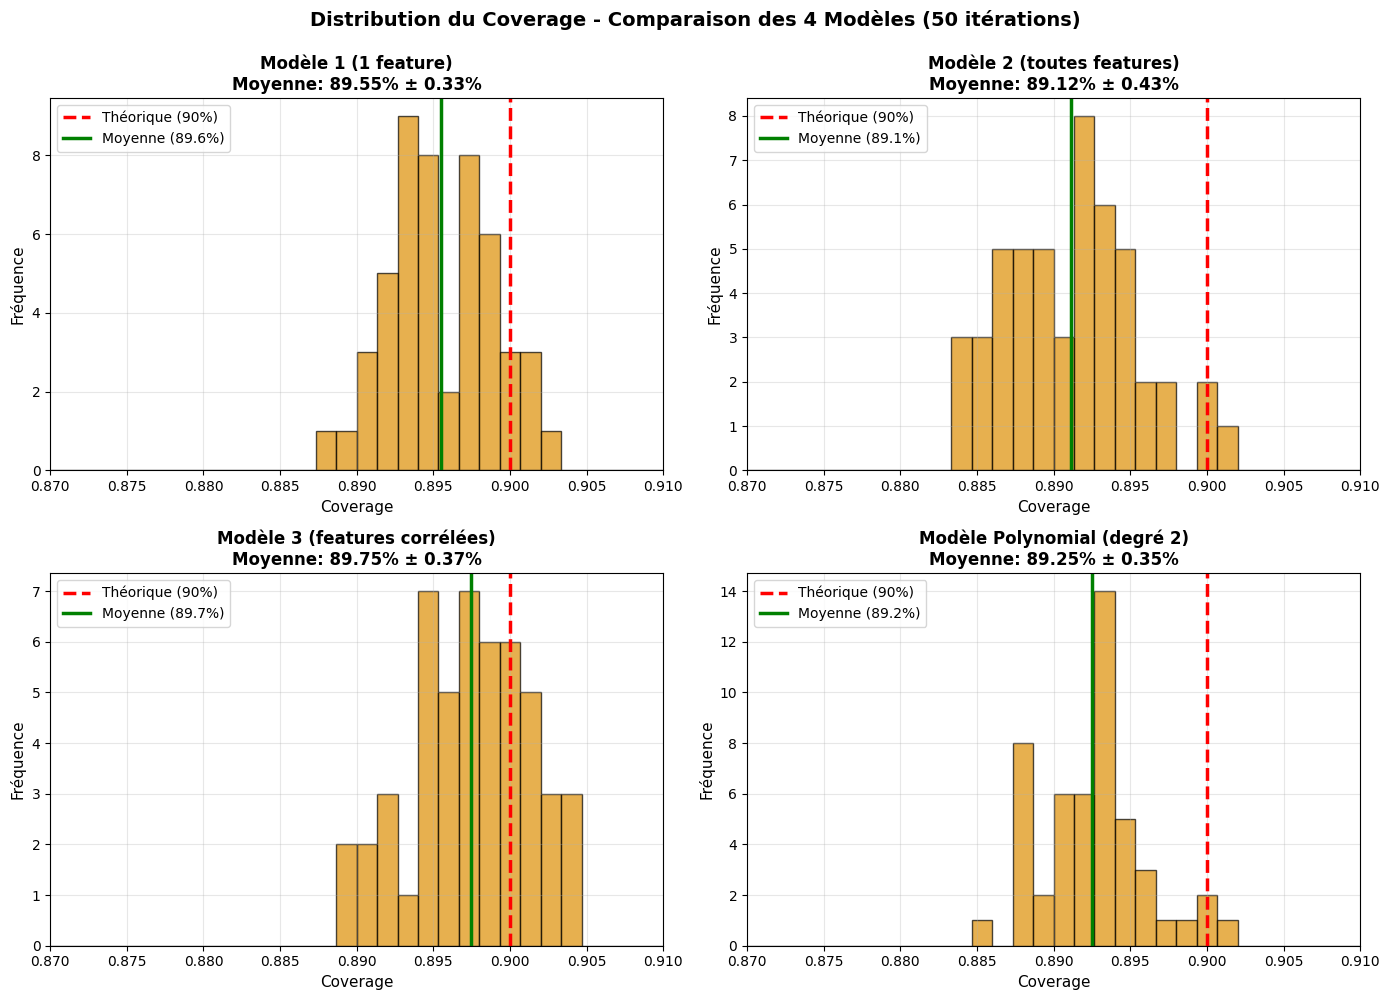

Statistiques de Coverage par Modèle:

Modèle 1 (1 feature):
  Moyenne: 89.55%
  Écart-type: 0.33%
  Min: 88.86%
  Max: 90.23%

Modèle 2 (toutes features):
  Moyenne: 89.12%
  Écart-type: 0.43%
  Min: 88.35%
  Max: 90.20%

Modèle 3 (features corrélées):
  Moyenne: 89.75%
  Écart-type: 0.37%
  Min: 88.91%
  Max: 90.38%

Modèle Polynomial (degré 2):
  Moyenne: 89.25%
  Écart-type: 0.35%
  Min: 88.52%
  Max: 90.18%


In [56]:
# Visualisation 1: Coverage des 4 modèles en 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

xlim_min = 0.87
xlim_max = 0.91
theor_cov = 0.9

# Configuration des modèles avec leurs coverages
models_coverage = [
    ('Modèle 1 (1 feature)', bootstrap_results['Modèle 1 (1 feature)']),
    ('Modèle 2 (toutes features)', bootstrap_results['Modèle 2 (toutes features)']),
    ('Modèle 3 (features corrélées)', bootstrap_results['Modèle 3 (features corrélées)']),
    (f'Modèle Polynomial (degré {degree})', coverages_poly)
]

# Plot pour chaque modèle
for idx, (model_name, coverages) in enumerate(models_coverage):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Histogramme
    ax.hist(coverages, bins=30, color=color_train, alpha=0.7, edgecolor='black', range=(xlim_min, xlim_max))
    
    # Ligne théorique
    ax.axvline(x=theor_cov, color='red', linestyle='--', linewidth=2.5, 
               label=f'Théorique ({theor_cov*100:.0f}%)')
    
    # Ligne moyenne
    mean_cov = np.mean(coverages)
    ax.axvline(x=mean_cov, color='green', linestyle='-', linewidth=2.5, 
               label=f'Moyenne ({mean_cov*100:.1f}%)')
    
    ax.set_xlabel('Coverage', fontsize=11)
    ax.set_ylabel('Fréquence', fontsize=11)
    ax.set_title(f'{model_name}\nMoyenne: {mean_cov*100:.2f}% ± {np.std(coverages)*100:.2f}%', fontsize=12, fontweight='bold')
    ax.set_xlim(xlim_min, xlim_max)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.suptitle('Distribution du Coverage - Comparaison des 4 Modèles (50 itérations)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Affichage des statistiques
print("Statistiques de Coverage par Modèle:")
print("="*60)
for model_name, coverages in models_coverage:
    print(f"\n{model_name}:")
    print(f"  Moyenne: {np.mean(coverages)*100:.2f}%")
    print(f"  Écart-type: {np.std(coverages)*100:.2f}%")
    print(f"  Min: {np.min(coverages)*100:.2f}%")
    print(f"  Max: {np.max(coverages)*100:.2f}%")

/home/r-one/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/home/r-one/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/home/r-one/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/home/r-one/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/home/r-one/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.w

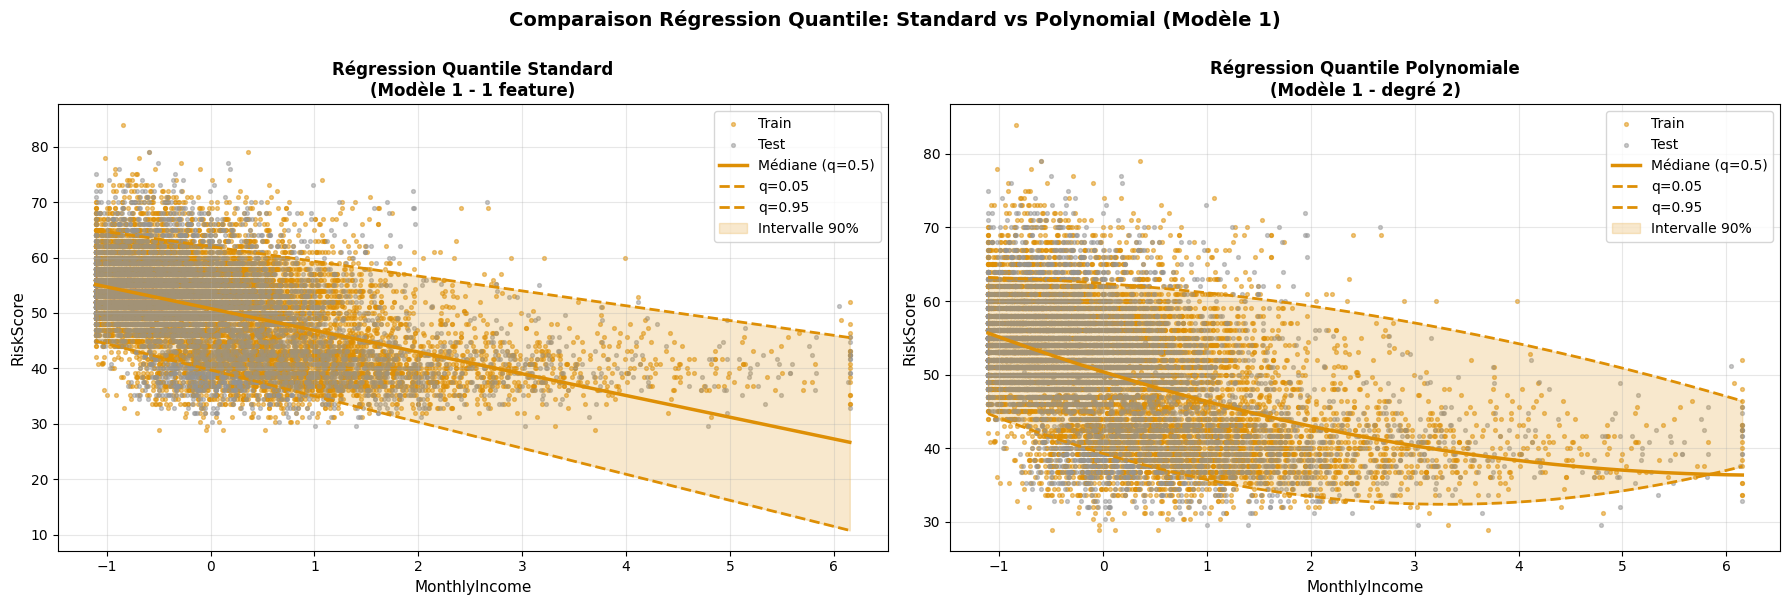


Comparaison des Métriques - Modèle 1:

Modèle Standard:
  MAE:  5.29
  RMSE: 6.84
  Couverture: 89.45%
  Largeur moyenne intervalle: 22.32

Modèle Polynomial (degré 2):
  MAE:  5.23
  RMSE: 6.75
  Couverture: 89.27%
  Largeur moyenne intervalle: 22.25


In [57]:
# Visualisation 2: Régression du Modèle 1 (1 feature) - Standard vs Polynomial en 1x2
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

feature_name = most_correlated
colors_blindness = sns.color_palette("colorblind")
color_train = colors_blindness[1]
color_test = colors_blindness[7]

# Modèle 1 Standard (gauche)
ax1 = axes[0]
ax1.scatter(X_train[most_correlated], y_train, marker='.', color=color_train, alpha=0.5, s=30, label='Train')
ax1.scatter(X_test[most_correlated], y_test, marker='.', color=color_test, alpha=0.5, s=30, label='Test')

# Prédictions pour la visualisation
X_plot = np.linspace(X_train[most_correlated].min(), X_train[most_correlated].max(), 500)
X_plot_full = X_plot[:, np.newaxis]

ax1.plot(X_plot, models['Modèle 1 (1 feature)'][0.5].predict(X_plot_full), 
         color=color_train, linewidth=2.5, label='Médiane (q=0.5)')
ax1.plot(X_plot, models['Modèle 1 (1 feature)'][0.05].predict(X_plot_full), 
         '--', color=color_train, linewidth=2, label='q=0.05')
ax1.plot(X_plot, models['Modèle 1 (1 feature)'][0.95].predict(X_plot_full), 
         '--', color=color_train, linewidth=2, label='q=0.95')

ax1.fill_between(X_plot, 
                  models['Modèle 1 (1 feature)'][0.05].predict(X_plot_full), 
                  models['Modèle 1 (1 feature)'][0.95].predict(X_plot_full), 
                  alpha=0.2, color=color_train, label='Intervalle 90%')

ax1.legend(fontsize=10)
ax1.set_xlabel(feature_name, fontsize=11)
ax1.set_ylabel('RiskScore', fontsize=11)
ax1.set_title('Régression Quantile Standard\n(Modèle 1 - 1 feature)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Modèle 1 Polynomial (droite)
ax2 = axes[1]
ax2.scatter(X_train_reduced.iloc[:, 0], y_train, marker='.', color=color_train, alpha=0.5, s=30, label='Train')
ax2.scatter(X_test_reduced.iloc[:, 0], y_test, marker='.', color=color_test, alpha=0.5, s=30, label='Test')

# Prédictions polynomiales pour la visualisation
aux = np.linspace(X_train_reduced.iloc[:, 0].min(), X_train_reduced.iloc[:, 0].max(), 500)
aux_poly = poly.transform(aux[:, np.newaxis])

ax2.plot(aux, models_poly[0.5].predict(aux_poly), 
         color=color_train, linewidth=2.5, label='Médiane (q=0.5)')
ax2.plot(aux, models_poly[0.05].predict(aux_poly), 
         '--', color=color_train, linewidth=2, label='q=0.05')
ax2.plot(aux, models_poly[0.95].predict(aux_poly), 
         '--', color=color_train, linewidth=2, label='q=0.95')

ax2.fill_between(aux, 
                  models_poly[0.05].predict(aux_poly), 
                  models_poly[0.95].predict(aux_poly), 
                  alpha=0.2, color=color_train, label='Intervalle 90%')

ax2.legend(fontsize=10)
ax2.set_xlabel(feature_name, fontsize=11)
ax2.set_ylabel('RiskScore', fontsize=11)
ax2.set_title(f'Régression Quantile Polynomiale\n(Modèle 1 - degré {degree})', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.suptitle('Comparaison Régression Quantile: Standard vs Polynomial (Modèle 1)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Comparaison des métriques
print("\nComparaison des Métriques - Modèle 1:")
print("="*60)
print(f"\nModèle Standard:")
print(f"  MAE:  {mae_m1:.2f}")
print(f"  RMSE: {rmse_m1:.2f}")
print(f"  Couverture: {couverture_m1:.2%}")
print(f"  Largeur moyenne intervalle: {largeur_moy_m1:.2f}")

print(f"\nModèle Polynomial (degré {degree}):")
print(f"  MAE:  {mae_poly:.2f}")
print(f"  RMSE: {rmse_poly:.2f}")
print(f"  Couverture: {couverture_poly:.2%}")
print(f"  Largeur moyenne intervalle: {largeur_moy_poly:.2f}")